# Project-1-Spotify

We are a consulting company for independent artists. We are helping a new Mexican artist to launch their next hit in Mexico and Latin America, which is planned to be released in last quarter 2020 in the Spotify platform, to remain in the Top 50 Chart throughout the next year.

Tasks:

* Identify most popular music genres in the population segment that the artist is targeting.
* Identify patterns in the tempo, energy, danceability and acousticness of the music that people in that segment listen to in different quarters.
* Define the properties that the artist's song should have to be succesful in last quarter 2020 in Mexico and Latin America.
* Predict how popular this song will be in upcoming quarters.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

top50_chart_df = pd.read_excel("chartmx_03_20.xlsx", index = False)
stats_df = pd.read_excel("audiofmx.xlsx", index = False)

top50_chart_df["id"] = top50_chart_df["URL"].str[-22:]

top50_chart_df = top50_chart_df[["Position", "Track Name", "Artist", "Date", "id"]]

top50_chart_df.head()

,Position,Track Name,Artist,Date,id
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-01,0mb7btREdC3wuIUmuVRgWn
1,2,El Año Viejo,Tony Camargo,2017-01-01,6NjhADkaWwGYO0R7eZXyI4
2,3,La Edad de los Países,Hernán Casciari,2017-01-01,5gA5Tvu7zlihzqUvmPUqoi
3,4,"Shake It Off - From ""Sing"" Original Motion Pic...",Nick Kroll,2017-01-01,2Q0WZoJaRJlelcxqOvowUc
4,5,Another Day Of Sun,La La Land Cast,2017-01-01,5kRBzRZmZTXVg8okC7SJFZ


In [2]:
stats_df = stats_df[["acousticness", "danceability", "duration_ms", "energy", "id", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]
stats_df.head()

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
0,0.00703,0.591,187853,0.901,0mb7btREdC3wuIUmuVRgWn,0.000000,10,0.0649,-4.328,0,0.1500,175.345,4,audio_features,0.694
1,0.60200,0.740,182720,0.521,6NjhADkaWwGYO0R7eZXyI4,0.000000,0,0.1110,-10.663,1,0.3650,159.694,4,audio_features,0.904
2,0.92300,0.606,280521,0.301,5gA5Tvu7zlihzqUvmPUqoi,0.000000,9,0.2970,-15.735,0,0.8610,62.876,3,audio_features,0.941
3,0.11600,0.741,120560,0.913,2Q0WZoJaRJlelcxqOvowUc,0.000001,11,0.0783,-5.453,1,0.2780,160.070,4,audio_features,0.854
4,0.01620,0.588,228173,0.742,5kRBzRZmZTXVg8okC7SJFZ,0.000004,8,0.6530,-6.757,1,0.0528,125.819,4,audio_features,0.824


In [3]:
complete_df = top50_chart_df.merge(stats_df, on = "id")
complete_df = complete_df[["Position", "Track Name", "Artist", "Date", "acousticness", "danceability", "duration_ms", "energy", "instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature", "type", "valence"]]
complete_df.head()

,Position,Track Name,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
0,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-01,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
1,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-02,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
2,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-03,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
3,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-04,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694
4,1,"I'm Still Standing - From ""Sing"" Original Moti...",Taron Egerton,2017-01-05,0.00703,0.591,187853,0.901,0.0,10,0.0649,-4.328,0,0.15,175.345,4,audio_features,0.694


## Hypothesis: If we determine the optimal mix of the variables related to a successful song in Mexico, then we can help the artist release a successful song in the last quarter of 2020:

## If the tempo of a song is higher than 100 bpm, then it will be more popular.

## If the chooses to release a reggaeton song, then it will remain in the Top 50 Chart throughout the next year.

## If a song has a higher level of energy, then it will be more likely to be in the Top 50 throughout the next year.

In [4]:
#Track name

In [5]:
track_name=complete_df.groupby(["Track Name"])
track_name.count().head()

,Position,Artist,Date,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,type,valence
Track Name,,,,,,,,,,,,,,,,,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
#Maldeamores,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
#Natural,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
(I Just) Died In Your Arms,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
(No One Knows Me) Like the Piano,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5


In [6]:
track_name_count=pd.DataFrame(track_name["Position"].count())
track_name_count.rename(columns={"Position":"Number of times in the chart TOP 50"},inplace=True)
track_name_count.head()

,Number of times in the chart TOP 50
Track Name,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6
#Maldeamores,10
#Natural,31
(I Just) Died In Your Arms,1
(No One Knows Me) Like the Piano,5


In [7]:
energy_data=pd.DataFrame(track_name["energy"].mean())
energy_data.rename(columns={"energy":"Energy"},inplace=True)
energy_data.head()

,Energy
Track Name,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",0.719000
#Maldeamores,0.804000
#Natural,0.824677
(I Just) Died In Your Arms,0.726000
(No One Knows Me) Like the Piano,0.198000


In [8]:
merge5_df=pd.merge(track_name_count, energy_data, on="Track Name", how="outer")
merge5_df

,Number of times in the chart TOP 50,Energy
Track Name,,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6,0.719000
#Maldeamores,10,0.804000
#Natural,31,0.824677
(I Just) Died In Your Arms,1,0.726000
(No One Knows Me) Like the Piano,5,0.198000
...,...,...
달라달라 (DALLA DALLA),10,0.853000
봄날의 소나기 Paper Umbrella,3,0.532000
전야 前夜 The Eve,1,0.702000


In [9]:
energy_h=merge5_df["Energy"]
position_h=merge5_df["Number of times in the chart TOP 50"]
correlation1 =stats.pearsonr(energy_h,position_h)
print(f"The correlation between both factors is {round(correlation1[0],2)}")

The correlation between both factors is 0.0


y =0.04x + 13.29
The r-squared is: 1.0151555145214378e-07


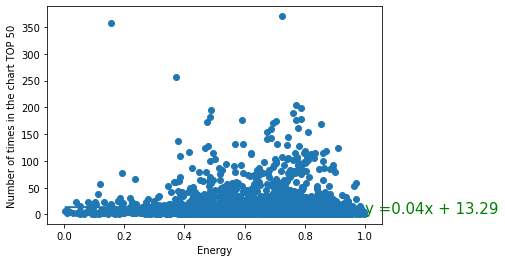

In [10]:
x_values_energyp=merge5_df["Energy"]
y_values_positionp=merge5_df["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values_energyp,y_values_positionp)
regress_values = x_values_energyp* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values_energyp, y_values_positionp)
plt.plot(x_values_energyp,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Energy")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()

In [11]:
#SAMPLE

In [12]:
subset=merge5_df.sample(90)
subset

,Number of times in the chart TOP 50,Energy
Track Name,,
El 7 De Fontana,21,0.632000
Todos Somos Rancius,1,0.982000
Hey Hey,1,0.593000
Baila Baila Baila,73,0.754000
Mejor Me Alejo,39,0.386333
...,...,...
Luz / Mujeres / Sanborns / 420,3,0.509000
Woman Like Me (feat. Nicki Minaj),14,0.850071
Dancing In My Head (Avicii's Been Cursed Remix),3,0.365000


In [13]:
energy_s=subset["Energy"]
position_s=subset["Number of times in the chart TOP 50"]
correlation2 =stats.pearsonr(energy_s,position_s)
print(f"The correlation between both factors is {round(correlation2[0],2)}")

The correlation between both factors is -0.19


y =-14.53x + 20.86
The r-squared is: 0.036027590844751656


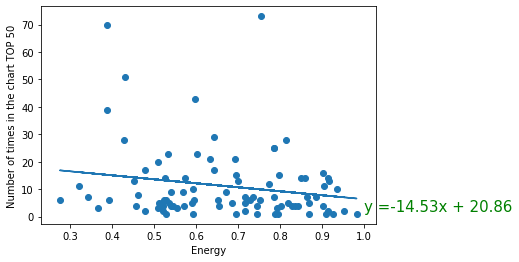

In [14]:
x_values_energys=subset["Energy"]
y_values_positions=subset["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values_energys,y_values_positions)
regress_values_sample = x_values_energys* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values_energys, y_values_positions)
plt.plot(x_values_energys,regress_values_sample)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Energy")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()

In [15]:
energy_boxplot=merge5_df["Energy"]

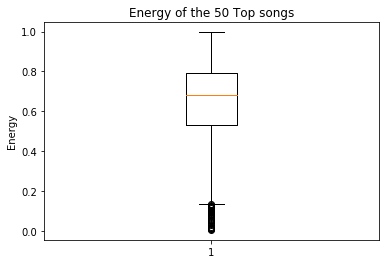

In [16]:
fig1, ax1 = plt.subplots()
ax1.set_title('Energy of the 50 Top songs')
ax1.set_ylabel('Energy')
ax1.boxplot(energy_boxplot)
plt.show()

In [17]:
energy_boxplot

Track Name
"Was He Slow?" - Music From The Motion Picture Baby Driver    0.719000
#Maldeamores                                                  0.804000
#Natural                                                      0.824677
(I Just) Died In Your Arms                                    0.726000
(No One Knows Me) Like the Piano                              0.198000
                                                                ...   
달라달라 (DALLA DALLA)                                            0.853000
봄날의 소나기 Paper Umbrella                                        0.532000
전야 前夜 The Eve                                                 0.702000
피카부 Peek-A-Boo                                                0.902000
항상 (HANGSANG)                                                 0.896000
Name: Energy, Length: 3367, dtype: float64

In [18]:
quar_energy=energy_boxplot.quantile([.25,.5,.75])
lowerq_energy=quar_energy[0.25]
upperq_energy=quar_energy[0.75]
iqr_energy=upperq_energy-lowerq_energy

print(f"The lower quartile of energy is: {lowerq_energy}")
print(f"The upper quartile of energy is: {upperq_energy}")
print(f"The upper interquartile range of energy is: {iqr_energy}")
print(f"The median of energy is: {quar_energy[0.5]}")

lower_bound_energy=lowerq_energy - (1.5*iqr_energy)
upper_bound_energy=upperq_energy + (1.5*iqr_energy)
print(f"Values below {lower_bound_energy} could be the outliers.")
print(f"Values above {upper_bound_energy} could be the outliers.")

The lower quartile of energy is: 0.5295000000000001
The upper quartile of energy is: 0.7940000000000003
The upper interquartile range of energy is: 0.2645000000000002
The median of energy is: 0.6813333333333333
Values below 0.1327499999999998 could be the outliers.
Values above 1.1907500000000004 could be the outliers.


In [19]:
filter_data=(merge5_df["Energy"]>=lower_bound_energy)&(merge5_df["Energy"]<=upper_bound_energy)
merge5_df.loc[filter_data]

,Number of times in the chart TOP 50,Energy
Track Name,,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6,0.719000
#Maldeamores,10,0.804000
#Natural,31,0.824677
(I Just) Died In Your Arms,1,0.726000
(No One Knows Me) Like the Piano,5,0.198000
...,...,...
달라달라 (DALLA DALLA),10,0.853000
봄날의 소나기 Paper Umbrella,3,0.532000
전야 前夜 The Eve,1,0.702000


In [20]:
energy_wo=merge5_df[(merge5_df>lower_bound_energy).all(1)]
energy_wo

,Number of times in the chart TOP 50,Energy
Track Name,,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6,0.719000
#Maldeamores,10,0.804000
#Natural,31,0.824677
(I Just) Died In Your Arms,1,0.726000
(No One Knows Me) Like the Piano,5,0.198000
...,...,...
달라달라 (DALLA DALLA),10,0.853000
봄날의 소나기 Paper Umbrella,3,0.532000
전야 前夜 The Eve,1,0.702000


In [21]:
energy_wo_data=energy_wo["Energy"]
position_wo_data=energy_wo["Number of times in the chart TOP 50"]
correlation3 =stats.pearsonr(energy_wo_data,position_wo_data)
print(f"The correlation between both factors is {round(correlation3[0],2)}")

The correlation between both factors is -0.01


## If a song has a higher level of danceability, then it will be more likely to be in the Top 50 throughout the next year.

In [22]:
dance_data=pd.DataFrame(track_name["danceability"].mean())
dance_data.rename(columns={"danceability":"Danceability"},inplace=True)
dance_data.head()

,Danceability
Track Name,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",0.754000
#Maldeamores,0.728000
#Natural,0.804613
(I Just) Died In Your Arms,0.625000
(No One Knows Me) Like the Piano,0.619000


In [23]:
merge_df=pd.merge(track_name_count, dance_data, on="Track Name", how="outer")
merge_df

,Number of times in the chart TOP 50,Danceability
Track Name,,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6,0.754000
#Maldeamores,10,0.728000
#Natural,31,0.804613
(I Just) Died In Your Arms,1,0.625000
(No One Knows Me) Like the Piano,5,0.619000
...,...,...
달라달라 (DALLA DALLA),10,0.790000
봄날의 소나기 Paper Umbrella,3,0.471000
전야 前夜 The Eve,1,0.636000


In [24]:
dance_p=merge_df["Danceability"]
position_p=merge_df["Number of times in the chart TOP 50"]
correlation4 =stats.pearsonr(dance_p,position_p)
print(f"The correlation between both factors is {round(correlation4[0],2)}")

The correlation between both factors is 0.15


y =22.78x + -1.31
The r-squared is: 0.022463035694865272


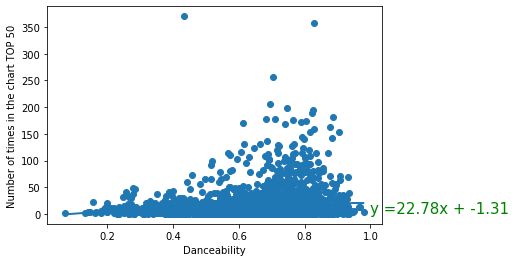

In [25]:
x_values_dancep=merge_df["Danceability"]
y_values_dposition=merge_df["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values_dancep,y_values_dposition)
regress_values2 = x_values_dancep* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values_dancep, y_values_dposition)
plt.plot(x_values_dancep,regress_values2)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Danceability")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()

In [26]:
#SAMPLE

In [27]:
subset_d=merge_df.sample(90)
subset_d

,Number of times in the chart TOP 50,Danceability
Track Name,,
We The Funk,7,0.680000
Vivo Pensando En Ti (feat. Maluma),93,0.797000
There for You,16,0.611000
Biking,3,0.673000
Watch (feat. Lil Uzi Vert & Kanye West),13,0.706000
...,...,...
Lisístrata,5,0.419000
DNA.,14,0.637857
TEMPTATION,7,0.775000


In [28]:
dance_s=subset_d["Danceability"]
position_s=subset_d["Number of times in the chart TOP 50"]
correlation5 =stats.pearsonr(position_s,dance_s)
print(f"The correlation between both factors is {round(correlation5[0],2)}")

The correlation between both factors is 0.19


y =36.48x + -8.79
The r-squared is: 0.03613671984237241


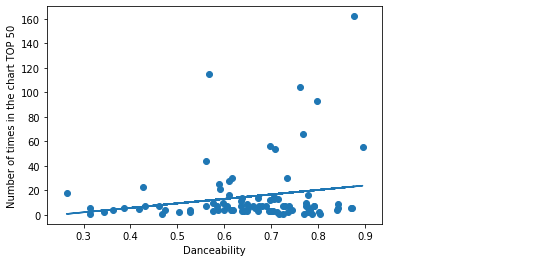

In [29]:
x_values=subset_d["Danceability"]
y_values=subset_d["Number of times in the chart TOP 50"]
(slope,intercept,rvalue,pvalue,stderr) = stats.linregress(x_values,y_values)
regress_values = x_values* slope + intercept
line_eq= "y ="+str(round(slope,2))+"x + "+ str(round(intercept,2))
print(line_eq)
plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values)

plt.annotate(line_eq,(1,2),fontsize=15,color="green")
plt.xlabel("Danceability")
plt.ylabel("Number of times in the chart TOP 50")

print(f"The r-squared is: {rvalue**2}")

plt.show()

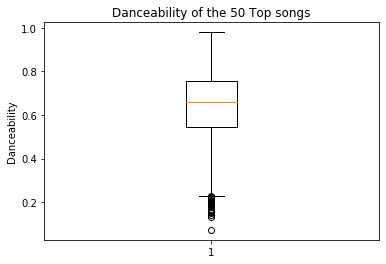

In [30]:
dance_boxplot=merge_df["Danceability"]
fig1, ax1 = plt.subplots()
ax1.set_title('Danceability of the 50 Top songs')
ax1.set_ylabel('Danceability')
ax1.boxplot(dance_boxplot)
plt.show()

In [31]:
quartiles_dance=dance_boxplot.quantile([.25,.5,.75])
lowerq_dance=quartiles_dance[0.25]
upperq_dance=quartiles_dance[0.75]
iqr_dance=upperq_dance-lowerq_dance

print(f"The lower quartile of danceability is: {lowerq_dance}")
print(f"The upper quartile of danceability is: {upperq_dance}")
print(f"The upper interquartile range of danceability is: {iqr_dance}")
print(f"The median of danceability is: {quartiles_dance[0.5]}")

lower_bound_dance=lowerq_dance - (1.5*iqr_dance)
upper_bound_dance=upperq_dance + (1.5*iqr_dance)
print(f"Values below {lower_bound_dance} could be the outliers.")
print(f"Values above {upper_bound_dance} could be the outliers.")

The lower quartile of danceability is: 0.545
The upper quartile of danceability is: 0.757
The upper interquartile range of danceability is: 0.21199999999999997
The median of danceability is: 0.661
Values below 0.2270000000000001 could be the outliers.
Values above 1.075 could be the outliers.


In [32]:
dance_wo=merge_df[(merge_df>lower_bound_dance).all(1)]
dance_wo

,Number of times in the chart TOP 50,Danceability
Track Name,,
"""Was He Slow?"" - Music From The Motion Picture Baby Driver",6,0.754000
#Maldeamores,10,0.728000
#Natural,31,0.804613
(I Just) Died In Your Arms,1,0.625000
(No One Knows Me) Like the Piano,5,0.619000
...,...,...
달라달라 (DALLA DALLA),10,0.790000
봄날의 소나기 Paper Umbrella,3,0.471000
전야 前夜 The Eve,1,0.636000


In [33]:
danc=dance_wo["Danceability"]
pos=dance_wo["Number of times in the chart TOP 50"]
corr =stats.pearsonr(danc,pos)
print(f"The correlation between both factors is {round(corr[0],2)}")

The correlation between both factors is 0.15
